# Monte-Carlo photon spectrum generation of inverse Compton scattering from a (weak) laser undulator #
Nov 2021
R. Loewen

## About the notebook ##

This is an interactive notebook to generate spectra for different ICS configurations. These configurations primarily address electron storage ring ICS sources.  The bunch frequency of a storage ring is well matched to that of an optical cavity, which builds up laser pulses at repetition rate of tens of MHz.  Since the interaction frequency is high, optical pulse energies are relatively low.

Given this context, we allow for a few assumptions. One is that the laser intensity is low enough that it acts as a weak undulator (K<<1). A second is that the interaction point (IP) is at an electron beam focus localized in $\hat{z}$.  By localized, we mean the focused spot is small compared to the distance from the IP to the output window. (Another common assumption is that there is no dispersion in the electron beam at the IP.)  The laser pulse is also considered to contain many undulator periods. Given the above assumptions, we treat the ICS interaction as a classic ***weak undulator***.

This notebook also contains some *Luminosity*, $\mathcal{L}$, calculations to estimate *flux* $\mathcal{L} \sigma_t$ (ph/s), where $\sigma_t$ is the Thomson cross section. The main purpose of the Monte Carlo code is to take a total number of scattered photons and calculate what happens to them.  This calculation gives the **relative intensity** both spatially and spectrally. If we know the $\mathcal{L}$, then we also know the spectral ph/s density distribution in angle space.

#convert this cell to code when running on Colab
from google.colab import drive
drive.mount('/content/drive/')

## Organize functions by using @dataclass  ##
The following figure conceptually illustrates the different classes in organizing the code. Below the figure is a list of dependencies.  We cover more details of each of the classes as we go through them.  Each `dataclass` section contains all its attributes and methods.  We follow each dataclass with another section illustrating some examples. Feel free to edit or play with them.
![dataclass_diagram.png](../pics/dataclass_diagram.png)
### Dependencies ###
The collected \[data\] is not a class itself.  It is a 4D (numpy) array representing the 4D photon *state space* for binning.
![class_dependency_block.png](../pics/class_dependency_block.png)
- **ebeam**() and **laser**() are independent 
  - **luminosity**(ebeam,laser) calculates flux, luminous spot size (and place to track errors)
  - **histogram** (ebeam, laser) to control how scattering data is collected
     - **aperture** (histogram) to calculate geometrical effects, transmission through window
        - **photons** (ebeam, laser, luminosity, aperture) for ICS calculations
- ‘main’ function of code is to call/convert **photons** -> **histogram \[data\]**
- **display**(data, histogram, aperture)
- **configuration**(ebeam, laser, luminosity, histogram, aperture) to save/recall configurations

### Naming convention ###
Every attibute and method defined **inside** a `dataclass` uses *mixedCase* style naming.
*underscore_names* are either from external libraries or temporary (working) variables outside of class definitions.

## Let's get started with import ##
First import packages that are used in project.

In [150]:
from dataclasses import dataclass
import math as m
import numpy as np
from scipy.interpolate import interp1d
from scipy.signal import find_peaks, peak_widths
from scipy import constants
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import time
# use a compiler for one C loop, otherwise inline (slower) code also works
%load_ext cython
# for saving/recalling configs
import pickle 
import tkinter as tk
from tkinter import filedialog

The cython extension is already loaded. To reload it, use:
  %reload_ext cython


In [151]:
# example constants we will use
print(constants.e)
print(f'electron rest mass in MeV {constants.m_e*constants.c*constants.c/constants.e*1e-6}')
print(f'Thomson {8*constants.pi/3*(constants.alpha*(constants.h/constants.m_e/constants.c)/2/constants.pi)**2}')

1.602176634e-19
electron rest mass in MeV 0.5109989499961641
Thomson 6.65245873221357e-29


## Class ebeam: ##
We define an **electron beam** at the IP to derive ebeam distributions. We will need: $E,\sigma_E$, $\sigma_x,\sigma_{x'}$, $\sigma_{y},\sigma_{y'}$ for the spectral modeling. The longitudinal attributes are mean energy (`.meanMeV`) and relative energy spread (`.sigmaErel`). Convenient transverse attributes are emittances, by default *normalized* (`.emittanceX`, `.emittanceY`) and beta functions at the IP (`.betastarX`,`.betastarY`).  (Coupling and correlations are not addressed.)  We include the option for specifying two more attributes, the bunch length (`sigmaZ`) and bunch charge (`bunchCharge`) for a *Luminosity* calculation available in the `luminosity` class.  The `ebeam` class also contains methods to generate random Gaussian distributions for batches of electrons. Those distributions are inputs for later scattering calculations. 


In [3]:
@dataclass
class ebeam:
    meanMeV:     float  # average energy (MeV)
    sigmaErel:   float  # relative energy spread dE/E
    emittanceX:  float  # usually normalized emittance (m)
    emittanceY:  float  #
    betastarX:   float  # beta* at IP (m)
    betastarY:   float  #
    useNormEmit: bool = True  # just in case, there are times we specify the geometric emittance instead
    sigmaZ:      float = 0.01 # (m) only need for correction to luminosity and spot size with crossing angle
    bunchCharge: float = 1e-9 # (Coulombs) only need for luminosity scaling, not spectrum
    def gamma(self):
        return self.meanMeV*1e6/(constants.m_e*constants.c*constants.c/constants.e)
    def emitX(self):
        return self.emittanceX/self.gamma() if self.useNormEmit else self.emittanceX
    def emitY(self):
        return self.emittanceY/self.gamma() if self.useNormEmit else self.emittanceY
    def sigmaX(self):
        return m.sqrt(self.emitX()*self.betastarX)
    def sigmaY(self):
        return m.sqrt(self.emitY()*self.betastarY)
    def sigmaXp(self):
        return m.sqrt(self.emitX()/self.betastarX)
    def sigmaYp(self):
        return m.sqrt(self.emitY()/self.betastarY)
    """ TBD: add functions to read equilibrium ICS energy distribution
          from storage ring turn-by-turn simulation (another code)"""
    # use beam parameters above to calculate sample electron(s) for ICS photon(s)
    # offsets in pointing (Xp,Yp) could come from luminosity or manually entered (like aperture misalignment)
    def eMeV(self, n=1):
        return np.random.default_rng().normal(self.meanMeV, self.meanMeV*self.sigmaErel, n)
    def esigmaXp(self, offset, n=1):
        return np.random.default_rng().normal(offset, self.sigmaXp(), n)  
    def esigmaYp(self, offset, n=1):
        return np.random.default_rng().normal(offset, self.sigmaYp(), n)

In [4]:
# example beam input
examplebeam = ebeam(44.5, 3.0e-3, 10e-6, 10e-6, 0.020, 0.020, True, 0.015)
#examplebeam = ebeam(237,7.81e-4,5.02e-6,5.02e-6, 10.0, 10.0, True, 0.010)
print(examplebeam)
print(examplebeam.gamma())
print(examplebeam.sigmaX())
print('here are 5 sample values for electron energy', examplebeam.eMeV(5))

ebeam(meanMeV=44.5, sigmaErel=0.003, emittanceX=1e-05, emittanceY=1e-05, betastarX=0.02, betastarY=0.02, useNormEmit=True, sigmaZ=0.015, bunchCharge=1e-09)
87.08432766903736
4.7923110232588027e-05
here are 5 sample values for electron energy [44.52142921 44.33705206 44.55040838 44.50281026 44.40175343]


## Class laser: ##
Define **optical parameters** of interaction laser. We assume here that the bandwidth of the optical pulse is much smaller than that of the electron beam energy spread. So we ignore it. We characterize the photon energy with only the laser wavelength (`.nm`).  (We neglect the finite oscillation bandwidth.) In other words, an optical pulse acts like an infinite period undulator.  Thus geometrical properties of the scattered optical photon do not contribute much to the spectral or spatial distribution of ICS.  Only through the luminous spot size, if large enough compared to the IP to exit-aperture distance, will it affect the ICS distribution.  The luminous (x-ray) spot size is calculated in the `lumunosity` dataclass.

In [5]:
@dataclass
class laser:
    nm: float                    # laser wavelength (nm)
    ps: float                    # polarization state, h=1, v=-1 or 0 for unpolarized
    zRayleighX:  float           # Rayleigh Range (m) in x
    zRayleighY:  float           # Rayleigh Range (m) in y
    psLength:    float = 25      # FWHM pulse length (ps) for luminosity effects only {sigma = c*(FWHM*1e-12)/2.35)}
    cavityPower: float = 100e3   # (W) for luminosity (implicitly includes interaction frequency!)
    def eV(self):
        return constants.h*constants.c/constants.e/(self.nm*1e-9)
    def sigmaX(self):
        return m.sqrt(self.nm*1e-9*self.zRayleighX/m.pi)/2
    def sigmaY(self):
        return m.sqrt(self.nm*1e-9*self.zRayleighY/m.pi)/2
    def mLength(self):
        return self.psLength*constants.c*1e-12/2.35

In [6]:
# example laser input
exampleNdYAG = laser(1064,1,0.03,0.03,235)
print(exampleNdYAG)
print(f'laser has photon energy of {exampleNdYAG.eV():0.4f} eV')
print(f'laser spot size sigma_x = {exampleNdYAG.sigmaX():0.2e}')
print(f'laser pulse length {exampleNdYAG.psLength} ps = {1000*exampleNdYAG.mLength():0.2f} mm')

laser(nm=1064, ps=1, zRayleighX=0.03, zRayleighY=0.03, psLength=235, cavityPower=100000.0)
laser has photon energy of 1.1653 eV
laser spot size sigma_x = 5.04e-05
laser pulse length 235 ps = 29.98 mm


## Class luminosity: ##

This class provides methods to calculate  *luminosity* or **total flux**.  To calculate *base flux* either specify the optional intensity inputs through `ebeam.bunchCharge` and `laser.cavityPower`, or accept default values.  (Since the total flux scales linearly with intensities, it is straightforward to scale afterwards.)  To include hourglass effects or other alignment errors, use the optional pulse length inputs for each beam, `ebeam.sigmaZ` and `laser.psLength`.

The class also contains methods to calculate luminous spot size. We generate spot size distributions here that will be used in the `photons` class.  There is a note on how the spot sizes affect angular distribution after the `aperture` class description.

The attributes of the class are the various errors in the collision geometry.  Those errors do two things: decrease the  luminosity and increase the luminous source size.

### Luminosity formulas ###
The base formula for the luminosity of two backscattered beams is conventionally stated as $\mathcal{L_0}$:
![base_luminosity.png](..\pics\base_luminosity.png)
We will take $N_1$ as number of laser photons, and $N_2$ as the number of electrons.  For our case, $N_b$ = 1 and the frequency of interaction $f$ is matched for each beam. It is convenient to fold the interaction rate $f$ in to the laser photons and use laser *power* as the relevant input.  The method `.baseFlux` calculates this $\mathcal{L_0}$ and multiplies it by the Thomson cross section to get the full bandwidth flux (ph/s) for a given configuration.
 
The above formula is the maximum luminosity and does not take into account variations in beam size or collision geometry. There are two different approaches coded here.  One is by S. White $^{\clubsuit}$ that independently derives expressions for *offsets*, *angles* and the *hourglass effect*.  The other formulation is by W. Herr and B. Muratori $^{\spadesuit}$ where all geometry effects are taken together and numerically integrated.  All of these methods return a *reduction factor* that should be multiplied by the base luminosity.

 $^{\clubsuit}$ Determination of the Absolute Luminosity at the LHC, S. White,	CERN-THESIS-2010-139 ; LAL-10-154
 
 $^{\spadesuit}$ Concept of Luminosity, W. Herr and B. Muratori, 0.5170/CERN-2006-002.361

#### Luminosity corrections (S. White) ####
We can apply *offsets* and *angles* to the collision and calculate the reduction factor by using the method `.angleOffsetReduction()`.  We can also independently calculate the *hourglass effect* by calling the method `.hourglassReduction()`. 
![luminosity_angles_offsets.png](..\pics\luminosity_angles_offsets.png)
**S** is the reduction due to angles, **T** to offsets, and **U** is a factor when both effects are present simultaneously.  These formulas have been analytically integrated for uncorrelated Gaussian beams.

The crossing angle factor also leads to an ***effective beam size*** increase, which we can use to adjust the luminous spot effect. This method `.luminousSpot()` returns a pair of spot sizes (for x,y).
![effective_spot_size.png](..\pics\effective_spot_size.png)

Since both beam waists vary as a function of position, the hourglass effect is harder to analytically integrate.  A numerical integration is straightforward if we use the following expression (and note that there is a missing squareroot in denominator of the integral).  The equivalent $\beta^*$ for an optical beam is the Rayleigh Range.
![hourglass_luminosity.png](..\pics\hourglass_luminosity.png)

#### Luminosity corrections (W. Herr and B. Muratori) ####
Below is a similar analysis by Herr and Muratori.  We put everything with an ***s*** dependence inside the integral and numerically evaluate it.  This method `.allReductions()` should work OK for small angle approximations and uncorrelated distributions.  It explicitly includes the *hourglass* waist changes for the *offsets* and *angles* computation.
![allFactors_luminosity.png](..\pics\allFactors_luminosity.png)

In [48]:
@dataclass
class luminosity:  # each 'error' attribute has two values - beam 1 (ebeam) and beam 2 (laser)
    phiX: [float]     # IP crossing angle (Rad) in horizontal
    dX:   [float]     # IP crossing offset (m) in horizontal
    phiY: [float]     # IP crossing angle (Rad) in vertical
    dY:   [float]     # IP crossing angle (Rad) in vertical
    dSx:  [float]     # IP waist offset in s (m) horizontal plane 
    dSy:  [float]     # IP waist offset in s (m) vertical plane 
    def baseFlux(self, ebeam, laser):  # interaction frequency is implied in laser power! (and matched to electron bunch frequency)
        Thomson = 8*constants.pi/3*(constants.alpha*(constants.h/constants.m_e/constants.c)/2/constants.pi)**2
        Nelectrons = ebeam.bunchCharge/constants.e
        NphotonsPerSec = laser.cavityPower/laser.eV()/constants.e
        numerator = Nelectrons*NphotonsPerSec      # interaction rate is folded in to laser power
        Xsq = laser.sigmaX()**2+ebeam.sigmaX()**2  # this would give 2*sigX**2 if both are equal
        Ysq = laser.sigmaY()**2+ebeam.sigmaY()**2
        denominator = 2*m.pi*m.sqrt(Xsq*Ysq)
        print(f'base flux estimate: {Thomson*numerator/denominator:0.3e} ph/s full bandwidth \
        ({1e9*ebeam.bunchCharge} nC electron bunch and {1e-3*laser.cavityPower} kW cavity power)')
        return Thomson*numerator/denominator        # this is the 'best case' or peak flux
    def luminousSpot(self, ebeam, laser):  # effective size of luminous spot
        sigX1sq = ebeam.sigmaX()**2*(1 + self.dSx[0]**2/ebeam.betastarX**2)
        sigY1sq = ebeam.sigmaY()**2*(1 + self.dSy[0]**2/ebeam.betastarY**2)
        sigX2sq = laser.sigmaX()**2*(1 + self.dSx[1]**2/laser.zRayleighX**2)
        sigY2sq = laser.sigmaY()**2*(1 + self.dSy[1]**2/laser.zRayleighY**2)
        lumSigX = m.sqrt(sigX1sq*sigX2sq/(sigX1sq + sigX2sq))
        lumSigY = m.sqrt(sigY1sq*sigY2sq/(sigY1sq + sigY2sq))
        # change of projected size due to angles
        dphiX = np.diff(self.phiX)
        dphiY = np.diff(self.phiY)
        Xsq = sigX1sq + sigX2sq
        Ysq = sigY1sq + sigY2sq
        Ssq = laser.mLength()**2 + ebeam.sigmaZ**2
        projectedX = m.sqrt(1 + Ssq/Xsq*(m.tan(dphiX/2))**2)
        projectedY = m.sqrt(1 + Ssq/Ysq*(m.tan(dphiY/2))**2)
        return lumSigX*projectedX, lumSigY*projectedY
    # use beam parameters to generate samples for spot size distributions to be applied to ICS photon(s)
    def lumSigmaX(self, ebeam, laser, n):
        return np.random.default_rng().normal(np.average(self.dX), self.luminousSpot(ebeam,laser)[0], n)
    def lumSigmaY(self, ebeam, laser, n):
        return np.random.default_rng().normal(np.average(self.dY), self.luminousSpot(ebeam,laser)[1], n)
    # apply luminosity discounts due to crossing angles, offsets, and hourglass effects
    def angleOffsetReduction(self,ebeam,laser):  # IP angles and offsets between the two beams
        sigX1sq = ebeam.sigmaX()**2*(1 + self.dSx[0]**2/ebeam.betastarX**2)
        sigY1sq = ebeam.sigmaY()**2*(1 + self.dSy[0]**2/ebeam.betastarY**2)
        sigX2sq = laser.sigmaX()**2*(1 + self.dSx[1]**2/laser.zRayleighX**2)
        sigY2sq = laser.sigmaY()**2*(1 + self.dSy[1]**2/laser.zRayleighY**2)
        Xsq = sigX1sq + sigX2sq
        Ysq = sigY1sq + sigY2sq
        Ssq = laser.mLength()**2+ebeam.sigmaZ**2
        dphiX = np.diff(self.phiX)   # we care about differences between beams for luminosity effects
        ddX = np.diff(self.dX)
        dphiY = np.diff(self.phiY)
        ddY = np.diff(self.dY)
        S = 1/m.sqrt(1+Ssq/Ysq*(m.tan(dphiY/2))**2 + Ssq/Xsq*(m.tan(dphiX/2))**2)               
        T = m.exp(-1*(ddX**2/2/Xsq + ddY**2/2/Ysq))
        U = m.exp(S*S*Ssq/2*((ddX*m.tan(dphiX/2)/Xsq)+(ddY*m.tan(dphiY/2)/Ysq))**2)
        return S*T*U # this factor should be <= 1
    def hourglassReduction(self, ebeam, laser, range_s=0.1):   # default range of integration should be OK ('longer' than bunches)
        s = np.linspace(-range_s, range_s, num = 1000)  # num large enough for numerical integration
        ssigX1sq = ebeam.sigmaX()**2*(1 + ((s - self.dSx[0])/ebeam.betastarX)**2)
        ssigY1sq = ebeam.sigmaY()**2*(1 + ((s - self.dSy[0])/ebeam.betastarY)**2)
        ssigX2sq = laser.sigmaX()**2*(1 + ((s - self.dSx[1])/laser.zRayleighX)**2)
        ssigY2sq = laser.sigmaY()**2*(1 + ((s - self.dSy[1])/laser.zRayleighY)**2)
        denominator = np.sqrt((ssigX1sq + ssigX2sq)*(ssigY1sq + ssigY2sq))
        numerator = np.exp(-2*s*s/(ebeam.sigmaZ**2+laser.mLength()**2))
        integral = np.trapz(numerator/denominator, x=s)
        result = integral/m.sqrt(2*m.pi**3*(laser.mLength()**2+ebeam.sigmaZ**2)) # compare this to baseFlux() denominator
        Xsq = laser.sigmaX()**2 + ebeam.sigmaX()**2
        Ysq = laser.sigmaY()**2 + ebeam.sigmaY()**2
        baseline = 1/(2*m.pi*m.sqrt(Xsq*Ysq))  # this is the same as denominator in baseFlux()
        return result/baseline   # this factor should be < 1
    def allReductions(self, ebeam, laser, sRange=0.1): # numerical integral of *everything!* combined
        Xsq = laser.sigmaX()**2 + ebeam.sigmaX()**2   
        Ysq = laser.sigmaY()**2 + ebeam.sigmaY()**2
        Ssq = laser.mLength()**2 + ebeam.sigmaZ**2
        s = np.linspace(-sRange, sRange, num = 1000)  # num large enough for numerical integration
        ssigX1sq = ebeam.sigmaX()**2*(1 + ((s - self.dSx[0])/ebeam.betastarX)**2)
        ssigY1sq = ebeam.sigmaY()**2*(1 + ((s - self.dSy[0])/ebeam.betastarY)**2)
        ssigX2sq = laser.sigmaX()**2*(1 + ((s - self.dSx[1])/laser.zRayleighX)**2)
        ssigY2sq = laser.sigmaY()**2*(1 + ((s - self.dSy[1])/laser.zRayleighY)**2)
        dphiX = np.diff(self.phiX)   # we care about differences between beams for luminosity effects
        ddX = np.diff(self.dX)
        dphiY = np.diff(self.phiY)
        ddY = np.diff(self.dY)
        ax = (m.sin(dphiX/2))**2/((ssigX1sq + ssigX2sq)/2)
        ay = (m.sin(dphiY/2))**2/((ssigY1sq + ssigY2sq)/2)
        A = ax + ay + (m.cos(m.sqrt(dphiX*dphiX + dphiY*dphiY)/2))**2/(Ssq/2) # add if in the exponent (small angle)
        Bx = ddX*m.sin(dphiX/2)/((ssigX1sq + ssigX2sq)/2)
        By = ddY*m.sin(dphiY/2)/((ssigY1sq + ssigY2sq)/2)
        B = Bx + By # add if in the exponent
        Wx = np.exp(-(ddX*ddX)/2/(ssigX1sq + ssigX2sq))
        Wy = np.exp(-(ddY*ddY)/2/(ssigY1sq + ssigY2sq))
        W = Wx*Wy # multiply if we take the exponent first
        intNumerator = W*np.exp(-(A*s*s + 2*B*s))
        intDenominator = np.sqrt((ssigX1sq + ssigX2sq)*(ssigY1sq + ssigY2sq))
        integral = np.trapz(intNumerator/intDenominator, x=s)
        reductionFactor = m.cos(dphiX/2)*m.cos(dphiY/2)/m.sqrt(m.pi)/m.sqrt(Ssq/2)*integral*m.sqrt(Xsq*Ysq)
        return reductionFactor  # should be < 1  (and likely larger than separately anglesOffset*hourglass)

In [49]:
exampleLum = luminosity([0.001,-0.001],[0,0],[0.00,-0.00],[0,0],[0.01,-0.01],[0,0])
print(exampleLum)
hourglassfactor = exampleLum.hourglassReduction(examplebeam,exampleNdYAG)
anglefactor = exampleLum.angleOffsetReduction(examplebeam,exampleNdYAG)
print(f'(hourglass {hourglassfactor:0.5})(angle/offset {anglefactor:0.5}) = {hourglassfactor*anglefactor:0.5}')
reductionfactor = exampleLum.allReductions(examplebeam,exampleNdYAG)
print(f'..compared to all-in-one reduction factor = {reductionfactor:0.5}')
print(exampleLum.luminousSpot(examplebeam,exampleNdYAG))

luminosity(phiX=[0.001, -0.001], dX=[0, 0], phiY=[0.0, -0.0], dY=[0, 0], dSx=[0.01, -0.01], dSy=[0, 0])
(hourglass 0.71112)(angle/offset 0.91387) = 0.64986
..compared to all-in-one reduction factor = 0.6843
(4.1280718383412535e-05, 3.472923777566978e-05)


## Class histogram: ##
Define **4D histogram** to assign bins to scattered angles and energies (x',y',E, p) where p is polarization (unpolarized=0, and linear sigma=1, pi=-1). This is the 'state space' we will use to calculate and then bin photons.  We treat x' and y' as having the same bin size and range for convenience.  We include methods to estimate the peak energy of scattered photons and apply a bandwidth of interest (from the peak energy down).  We can also take advantage of the photon distribution (described in the following section) to preset the range of sampled energies.  If we collect a range of energies, we can restrict the Monte Carlo random variable to this range.  This saves us from throwing away out-of-band photons.  We still track out-of-bound photons by including extra bins in the `histogram.createArray()`.  The data includes out-of-bound low and high indexes for x' y' and E (but not p) so we can account for all photons created.

### Monte-Carlo ICS part 1: mapping energy to a random sampling function ###
The histogram methods include calculations about which energies to track.  For this, we need the undulator photon distribution.  This is a good spot to illustrate the relevant formulas.  I am using Hofmann([^1]), in particular, his analysis of weak undulators.  The most useful formula to start with is the **power spectral density**, which is the power integrated over the solid angle.  We use Hofmann's formula for ***S<sub>u</sub>*** that combines both sigma and pi polarizations to include all photons. From ***S<sub>u</sub>*** we divide by photon energy to get the classic **photon distribution** "U" shaped ***P<sub>u</sub>***.  Next we integrate to get a normalized monotonic function ***CP<sub>u</sub>***.  This is the function we invert and sample (with random *P*) to get *x*, the normalized photon energy.

For individual electrons, that electron's energy determines the peak photon energy.  For the histogram, we calculate top energy from the estimated peak of the electron beam energy distribution. The `minP()` method looks at the lowest energy bin in the histogram and uses that to set the bandwidth, or lowest energy to sample with *P(x)*.  For example, if the lowest energy we want is 80% of the estimated peak, then the corresponding *minP* = 0.752 (green arrows). Using the inverse of ***CP<sub>u</sub>***, a random sampling above *minP* will fill in the appropriate upper part of curve ***P<sub>u</sub>***. (Later, in the `photons` dataclass,  we will talk about the inverse of ***CP<sub>u</sub>*** .)
![ICS_photon_distribution.png](../pics/ICS_photon_distribution.png)

[^1]: files/Hofmann_synchrotron_radiation.pdf

In [9]:
@dataclass
class histogram:
    theta: float     # largest +/- angle for x' and y' (rad)
    dtheta: float    # size of each angle bin (rad)
    minE: float      # lowest energy bin (eV)
    maxE: float      # highest energy bin (eV)
    dE: float        # size of each energy bin (eV)
    def estimateMaxE(self, ebeam, laser, precision=0):   # add +6dE/E and round from there
        gamma2 = ((1+6*ebeam.sigmaErel)*ebeam.gamma())**2  # use this as upper bound for gamma^2
        return round(4*gamma2*laser.eV()/(1 + 4*gamma2*laser.eV()/(1e6*ebeam.meanMeV)), precision)
    def autoMaxE(self, ebeam, laser, precision = -3):
        newMaxE = self.estimateMaxE(ebeam, laser, precision)
        print(f'  ...new max {newMaxE:0.0f} replaces {self.maxE:0.0f} as histogram.maxE')
        self.maxE = newMaxE
        return
    def setBW(self, bandwidth=1, precision=-3):    # call after checking or setting it with autoMaxE()
        if bandwidth > 1.0: bandwidth = 1.0, print('bandwidth must be <1')
        else:
            newMinE = round((1-bandwidth)*self.maxE, precision) 
            print(f'  ...new min {newMinE:0.0f} replaces {self.minE:0.0f} as histogram.minE')
            self.minE = newMinE
        return
    def binsE(self):
        return int((self.maxE - self.minE)/self.dE) + 2  # +2 for out-of-bounds collection +/-
    def binsEArray(self):
        return np.linspace(self.minE, self.maxE, self.binsE() - 2)  # don't include out-of-bounds for search
    def binsTheta(self):
        return int(2*self.theta/self.dtheta) + 2 # +2 for out-of-bounds collection +/-
    def binsThetaArray(self):
        return np.linspace(-1*self.theta, self.theta, self.binsTheta() - 2) # don't include out-of-bounds
    def minP(self, ebeam, laser):   # P[0..1] but we don't need to track low energy photons -> P[minP..1] 
        fractionE = m.floor(100*self.minE/self.estimateMaxE(ebeam,laser,-3))/100  # round down to nearest %
        minP = 3/2*fractionE - 3/2*fractionE**2 + fractionE**3  # this is lower bound of what we need to sample
        return minP, 1-fractionE  # we use minP later, but we can also use the bandwidth to scale output flux correctly
    def createArray(self):        # for now, put in 3 bins for polarization (unpolarized and two for linear)
        return np.zeros((self.binsTheta(), self.binsTheta(), self.binsE(), 3), dtype=np.int64)  # 64bit for cython 

In [10]:
# example histogram input
#examplehist = histogram(4e-3, 80e-6, 10e3, 40e3, 200)
examplehist = histogram(1e-3, 50e-6, 980e3, 1020e3, 400)
print(f'initial {examplehist}')
print('If we want, we can calculate and set the min and max energies')
print(examplehist.estimateMaxE(examplebeam,exampleNdYAG,-1))
examplehist.autoMaxE(examplebeam,exampleNdYAG,-3)   #to set the high energy cutoff (call first)
examplehist.setBW(0.03)                              #to set the low energy cutoff
print(f'modified to {examplehist}')
#print(examplehist.binsThetaArray())
# use histogram settings to define array
exampledata = examplehist.createArray()
print(f"{exampledata.shape} are the available bins to put a scattered photon in (x', y', E, p) space")
minP = examplehist.minP(examplebeam,exampleNdYAG)[0]
BW = examplehist.minP(examplebeam,exampleNdYAG)[1]
print(f'minimum P [0..1] is {minP} for a sampled BW of {BW*100:0.1f}%')

initial histogram(theta=0.001, dtheta=5e-05, minE=980000.0, maxE=1020000.0, dE=400)
If we want, we can calculate and set the min and max energies
36600.0
  ...new max 37000 replaces 1020000 as histogram.maxE
  ...new min 36000 replaces 980000 as histogram.minE
modified to histogram(theta=0.001, dtheta=5e-05, minE=36000.0, maxE=37000.0, dE=400)
(42, 42, 4, 3) are the available bins to put a scattered photon in (x', y', E, p) space
minimum P [0..1] is 0.9563230000000001 for a sampled BW of 3.0%


## Class aperture: ##
Create an **aperture** to define a mask geometry for angular acceptance.  The aperture can also define output window characteristics, like attenuation. This also makes a good detector plane where we can specify source to output distance.  This distance converts luminous source size to angles (see section after aperture examples below).  Since the output aperture may be part an optical mirror (as in the Lyncean CLS), we include features of the substrate as well as the 'thinned' output area. The 'thick' substrate may affect the geometrical acceptance, like a tilt angle of an otherwise circular aperture. For the thin part of the output window, we use data from a lookup table available from NIST* to calculate energy dependent transmission. Silicon is the default material.

*<https://physics.nist.gov/PhysRefData/FFast/html/form.html> and pick 2.00-433keV, for example, and save as text file.

In [11]:
@dataclass
class aperture:
    toIP: float           # distance from aperture to IP (m)
    dia: float            # diameter of circular hole (m)
    thick: float = 0      # thickness of aperture, such as substrate of a locally thinned optic (m)
    angle: float = 0      # tilt angle, as from an optic substrate in a cavity (deg)
    thin: float = 0       # thickness of apertured window itself (m)
    material: str = 'Si'  # silicon is nominal material - can add others as needed
    #below are some aperture methods that require a given histogram ('detector' plane) 
    def transmission(self, hist):
        if self.thin <= 0:
            return np.ones(hist.binsE())
        elif self.material == 'Si':
            SiNIST = np.loadtxt("NIST_Si_mu_table_2-433keV.txt", delimiter="\t")
            mu = np.interp(hist.binsEArray(), SiNIST[:,0]*1e3, SiNIST[:,1])
            transmission = np.exp(-mu*self.thin*100)
            return np.roll(np.append(transmission,[0,0]),1) # add 0's to out-of-bounds energies
        else:
            print(f'{self.material} not a recognized material, no attenuation loaded')
            return np.ones(hist.binsE())
    def createMask(self, hist):    # create a 'hard' aperture by creating a 2D array of 0's and 1's (histogram sized)
        offsetm = m.sin(m.radians(self.angle))*self.thick    # cylinder tilt offset in m
        offset = m.atan(offsetm/2/self.toIP)/hist.dtheta     # m offset converted to histogram bins ('angle' space)
        midpoint = hist.theta/hist.dtheta + 1                # default is calculate everything in bins (+1 for oob)
        well = m.atan(self.dia/2/self.toIP)/hist.dtheta      # nominal radius of well
        left = midpoint - offset                             # each tilted edge appears transversely shifted
        right = midpoint + offset
        endpoint = int(2*midpoint)
        maskleft = np.empty([endpoint,endpoint])            # populate a mask to fill in with 0's or 1's
        maskright = np.copy(maskleft)                       # do each side independently
        for x in range(0, endpoint):
            for y in range(0, endpoint):
                maskleft[x,y] = 1 if (((x-left)**2+(y-midpoint)**2) <= well**2) else 0
                maskright[x,y] = 1 if (((x-right)**2+(y-midpoint)**2) <= well**2) else 0
        mask = maskleft * maskright                        # combine as 'AND'ed set for aperture
        return mask
    def properties(self, hist):   # a place to assemble some aperture calculations that may be interesting to know
        mymask = self.createMask(hist)
        # max subtended angles in each plane
        radWidth = hist.dtheta*np.sum(mymask[:,int(mymask.shape[0]/2)])  # count 1's across the middle
        radHeight = hist.dtheta*np.sum(mymask[int(mymask.shape[1]/2),:])
        # area covered by aperture
        relArea = np.sum(mymask)/((mymask.shape[0]-2)*(mymask.shape[1]-2))  # how much of histogram covered by aperture
        mmAreaHistoram = (m.sin(hist.theta)*self.toIP*2*1e3)**2
        mmArea = relArea*mmAreaHistoram
        return radWidth, radHeight, mmArea

In [12]:
# example aperture input
examplewindow = aperture(1.25,10e-3,12.7e-3,6.0,1e-3,'Si')
print(examplewindow)
print('transmission calculated for', examplewindow.transmission(examplehist).size, 'energies')
ans = examplewindow.createMask(examplehist)
print(ans.shape)
#print(examplewindow.transmission(examplehist))
luminous_angleX = exampleLum.luminousSpot(examplebeam,exampleNdYAG)[0]/examplewindow.toIP
print(f"sigma of x' distribution due to luminous spot = {luminous_angleX}")

aperture(toIP=1.25, dia=0.01, thick=0.0127, angle=6.0, thin=0.001, material='Si')
transmission calculated for 4 energies
(42, 42)
sigma of x' distribution due to luminous spot = 3.302457470673003e-05


### Note on luminous spot size ###

Since we are tracking *angle space* (x', y') of photons, we can pick any length past the aperture as the detector plane.  The most natural plane to take a look is right where we put an output window, or aperture. This is usually far from the source compared to the source size.  In this case, simple geometry determines the angular effect of the luminous spot size. We get **d** in the figure below from the attribute `aperture.toIP` distance.
![source_size_angles.png](../pics/source_size_angles.png)

## Class configuration: ##
Here we assemble some simple utilities to store configurations and recall them later. We define a *configuration* as the attributes of the preceding dataclasses `ebeam`, `laser`, `luminosity`, `histogram`, and `aperture`.

In [15]:
@dataclass
class configuration:
    mybeam: ebeam = 0
    mylaser: laser = 0
    myluminosity: luminosity = 0
    myhistogram: histogram = 0
    myaperture: aperture = 0
    currentPath: str = ''
    def save(self):
        root = tk.Tk()
        root.attributes("-topmost", True)
        root.withdraw()
        filepath = filedialog.asksaveasfilename(parent=root,title='Save an ICS config',defaultextension=".icsc")
        self.currentPath = filepath
        file = open(filepath, 'wb')
        pickle.dump((self.mybeam,self.mylaser,self.myluminosity,self.myhistogram,self.myaperture), file)
        file.close()
        return
    def recall(self):
        root = tk.Tk()
        root.attributes("-topmost", True)
        root.withdraw()
        filepath = filedialog.askopenfilename(parent=root,title='Choose a config',filetypes=[("ICS configs", "*.icsc")])
        self.currentPath = filepath
        file = open(filepath, 'rb')
        (self.mybeam,self.mylaser,self.myluminosity,self.myhistogram,self.myaperture) = pickle.load(file)
        file.close()
        return

In [149]:
# example config input
exampleconfig = configuration(examplebeam,exampleNdYAG,exampleLum,examplehist,examplewindow)
print(exampleconfig)
#exampleconfig.save()

configuration(mybeam=ebeam(meanMeV=44.5, sigmaErel=0.003, emittanceX=1e-05, emittanceY=1e-05, betastarX=0.02, betastarY=0.02, useNormEmit=True, sigmaZ=0.015, bunchCharge=1e-09), mylaser=laser(nm=1064, ps=1, zRayleighX=0.03, zRayleighY=0.03, psLength=235, cavityPower=100000.0), myluminosity=luminosity(phiX=[0.001, -0.001], dX=[0, 0], phiY=[0.0, -0.0], dY=[0, 0], dSx=[0.01, -0.01], dSy=[0, 0]), myhistogram=histogram(theta=0.001, dtheta=5e-05, minE=36000.0, maxE=37000.0, dE=400), myaperture=aperture(toIP=1.25, dia=0.01, thick=0.0127, angle=6.0, thin=0.001, material='Si'), currentPath='')


## Class photons: ##
This is where we calculate ICS and generate the states (as attributes) of a collection of **photons**.  The main method called is `scatter()` which assigns values to the four photon attributes. First it generates a set of Monte-Carlo 'x' (normalized photon energy) values `Px`. For a particular `Px` we know the energy of the photon `.eV`.  The next calculation determines the polarization `.ps` (if laser photons are linearly polarized).  The polarization state affects the angular distribution in x', y' space. Knowing the polarization and photon energy, we determine the angles x', y' or `.xp`, `.yp`.  

The trick here is to use `Numpy` as much as possible, so we vectorize everything with arrays. In other words, we calculate a batch of photons at a time, for instance 1M, and then add them to a data histogram.  We may add batches of photons to the histogram data by calling the same `scatter()` method.

The following description of ICS calculations consider a single electron at a time.  We can add the effects of the electron beam distribution as we go along, or at the end.  Similarly for the luminous spot effect.  If we add beam correlations from position  ($\sigma_x$) to angle space ($\sigma_{x'}$), we would have include it as we go.  For the case where the beam is not correlated, we can add in the effects at the very end.

### Monte-Carlo ICS part 2: scattering formulas ###
We start with generating the ***P<sub>u</sub>*** photon distribution as samples `Px` from a uniform random number distribution [0..1]. We can limit the range by setting a floor for P(x), called from `histogram.minP()`. The integrated formula that we need is the inverse of ***CP<sub>u</sub>*** shown earlier in the `histogram` section.  This is simple enough to be algebraically inverted.  (And each axis is already normalized to unity.)
From Maple, we get the inverse of ***CP<sub>u</sub>***, which is coded in `.generatePx()`:
![inverted_MC_formula.png](..\pics\inverted_MC_formula.png)

The *undulator formula* gives us the backscattered photon energy. It includes the recoil term in the denominator, which is relevant for gamma-ray energies.  The maximum energy is straight ahead, $\theta=0$.  The normalized photon energy $E_{ph}/E_{max}$ is the `Px` we generated with our Monte-Carlo distribution.
![undulator_eq_insert.png](..\pics\undulator_eq_insert.png)

Once we specify the normalized energy of a scattered photon, the $\theta$ component is correlated exactly (with a factor of $\gamma$).  This angle is relative to where the electron is pointing ($\theta\equiv0$).  The coordinate system we use is:
![geometry.png](..\pics\geometry.png)

The last piece of information we need is the angle $\phi$ distribution. The angle $\phi$ depends on the plane of polarization, and the polarization mode ($\sigma$ or $\pi$).  If unpolarized, I set $\phi$ to be randomly distributed over $2\pi$. If we have a linearly polarized laser in $\hat{x}$, there will mostly be $\sigma$-mode polarization at low angles, or high energies. There is a mix of $\pi$-mode at larger angles, as seen in the following figure.  
![photon_distribution.png](..\pics\photon_distribution.png)

Taking advantage of Hofmann's analysis, the problem can be split up in to two parts. First, we determine what polarization the photon has. For this, we go back to the **power spectral density** formulas, but this time we use the one for ***S<sub>u$\sigma$</sub>*** as well as ***S<sub>u</sub>***.
![power_spectral_density.png](..\pics\corrected_spectral_power_density.png)

For a given `Px` (in Hofmann's notation $\frac{\omega}{\omega_{10}}$) we find the ratio of ***S<sub>u$\sigma$</sub>*** compared to the sum ***S<sub>u</sub>***.  A random number determines whether the photon is $\sigma$- or $\pi$-mode.  Once we know the polarization state, we use the **spectral angular power**, which contains the explicit $\phi$ dependence, to make a distribution that matches these functions
![spectral_angular_power.png](..\pics\spectral_angular_power_for_phi.png)

The dataclass contains two different methods that should allow us to find $\phi$.  One is the `explicitPhi()` calculation that first generates a function for a particular `Px`.  Integrating this function creates a map of $\phi$ to a random number.  (This method is not presently working. To make it work for inverting 2D inputs, it requires building another function to handle broadcasting correctly.) The second method is an `interpolatePhi()` routine which interpolates both `Px` and $\phi$ from a 2D lookup table.  We generate the table once, then use it to find $\phi$ given `Px` and a random number.  This second method is  working (although likely slower than it should be.)

In [13]:
@dataclass
class photons:
    xp : [float]   # horizontal angles (rad)
    yp : [float]   # vertical angles (rad)
    eV : [float]   # energies (eV)
    ps : [float]   # polarization states (sigma=1, pi=-1, unpolarized=0)
    def scatter(self, n, ebeam, laser, table, minP=0): # top function to modify photon attibutes for n given random P(x)'s
        Px = self.generatePx(n, minP)   # inverted Monte Carlo probability distribution [Pmin..1]
        self.eV = self.energy(ebeam, laser, Px)           # energy of scattered photon
        self.ps = self.polarization(Px) if laser.ps != 0 else np.zeros(n)  # polarization state depends on P(x)
        self.xp, self.yp = self.angles(ebeam, laser, Px, table)  # call polarization first because we read .ps attribute
        return
#   Below are methods called from scatter(), starting with the undulator photon energy distribution P(x)
    def generatePx(self, n, minP=0):  # MC probability function for weak undulator, mapping energy of scattered photon
        y = minP + np.random.random(n)*(1 - minP)
        term = -2 + 4*y + np.sqrt(5 - 16*y + 16*y*y)
        return (term**(2./3) -1 + term**(1./3))/2/term**(1./3)
    def energy(self, ebeam, laser, Px):   # once we know P(x) we can easily scale from max energy
        n = np.size(Px)
        gamma2 = (ebeam.eMeV(n)*1e6/(constants.m_e*constants.c*constants.c/constants.e))**2
        maxE = 4*gamma2*laser.eV()/(1 + 4*gamma2*laser.eV()/(1.0e6*ebeam.eMeV(n)))
        return Px*maxE
    def polarization(self, Px):         # first determine probability for s or p (assuming planar undulator)
        Su = (1 - 2*Px + 2*Px*Px)       # spectral photon density from Hofmann for sum of sigma + pi
        Sus = (1/2 - Px + 3/2*Px*Px)    # spectral photon density from Hofmann for sigma only
        ratio = Sus/Su                  # use ratio as threshold for determining which state
        p = np.where(np.less(np.random.random(np.size(ratio)), ratio), 1, -1)
        return p
    def angles(self, ebeam, laser, Px, table):
        n = np.size(Px)
        gamma2 = (ebeam.eMeV(n)*1e6/(constants.m_e*constants.c*constants.c/constants.e))**2
        theta = np.sqrt((1-Px)/Px/gamma2)                # full angle theta known (although not phi yet)
        phi = self.interpolatePhi(self.ps, Px, table)[1] # returns functional polarization dependent phi distribution
        if laser.ps == 0: phi = phi + m.pi/2             # above is laser vertical polarization; rotate if horizontal
        thetaX = theta*np.cos(phi) #+ ebeam.esigmaXp(0, n)  # manage uncorrelated stuff in a separate method!
        thetaY = theta*np.sin(phi) #+ ebeam.esigmaYp(0, n)  # ...these act like a convolution to ICS distribution
        return thetaX, thetaY
    def interpolatePhi(self, ps, Px, table):  # generate lookup table first, then interpolate for specific P (works!)
        x = np.random.random(np.size(Px))  # for sampling monte-carlo cumulative phi distribution (and invert to get phi)
        def multiInterp(x, X, Y):   # a vectorized explicit interpolation for inverting
            dX = np.diff(X, axis=0)
            dY = np.diff(Y, axis=0)
            w = np.clip((x - X[:-1, :])/dX[:, :], 0, 1)
            return np.sum(w*dY[:,None], axis=0)    
        def sigmaPhi(x, Px, table):
#            a = time.perf_counter()
            pFracIndex = np.interp(Px, table[0], np.arange(np.size(table[0])))
#            b = time.perf_counter()
            myInterp = interp1d(np.arange(np.size(table[0])),table[2].T)  #'from scipy.interpolate import interp1d'
            phiFunction = myInterp(pFracIndex)          
#            c = time.perf_counter()
            ans = multiInterp(x,phiFunction,table[1])       # use a vectorized interpolation
            d = time.perf_counter()
#            print(f'{b - a:0.5f} ; {c - b:0.5f} ; {d - c:0.5f}')
            return ans 
        def piPhi(x, table):  # invert axes to sample CP function to return value for phi
            return np.interp(x, table[3], table[1])
        value = np.where(ps != 0, np.where(ps==1, sigmaPhi(x, Px, table), piPhi(x, table)), x*2*m.pi)
        return x, value       # return both to check function; otherwise just need 'value' for actual phi
    def generatePphiTable(self, p, n, Pfloor=0.01):   # do this once and use interpolatePhi() to invert
        samplesP = np.linspace(Pfloor, 1.0, p)
        samplesPhi = np.linspace(0, 2*m.pi ,n)
        CPps = np.empty([p,n]) # s polarization phi distribution is dependent on photon energy
        CPp = np.empty([n])    # p polarization phi distribution is independent of photon energy
        for x, P in np.ndenumerate(samplesP):
            A = (1-P)/P
            for y, phi in np.ndenumerate(samplesPhi):
                CPps[x,y] = (4*phi-4*A*m.sin(2*phi)+A*A*m.cos(2*phi)*m.sin(2*phi)+2*A*A*phi)/4/m.pi/(2+A*A)
        for y, phi in np.ndenumerate(samplesPhi):
                CPp[y] = (-m.cos(2*phi)*m.sin(2*phi)+2*phi)/4/m.pi
        return samplesP, samplesPhi, CPps, CPp
#   Below are methods that modify our 'point source' ICS photon distribution after the fact.
#   We could make a copy of the base ICS distribution and change (non-energy aspects) of ebeam/laser/aperture
    def addBeamDivergence(self, ebeam, luminosity):  # set offsets to '0' to center beam to aperture
        n = np.size(self.xp)
        self.xp = self.xp + ebeam.esigmaXp(luminosity.phiX[0], n)
        self.yp = self.yp + ebeam.esigmaYp(luminosity.phiY[0], n)
        return
    def addLuminousSpot(self, ebeam, laser, luminosity, aperture):  # convert source position to angles
        n = np.size(self.xp)
        self.xp = self.xp + (luminosity.lumSigmaX(ebeam, laser, n) + np.average(luminosity.dX))/aperture.toIP
        self.yp = self.yp + (luminosity.lumSigmaY(ebeam, laser, n) + np.average(luminosity.dY))/aperture.toIP
        return

photons(xp=array([-0.1234509 ,  0.03831243,  0.00092755, -0.06429149, -0.0029243 ,
       -0.0007616 , -0.00602327,  0.00374132,  0.00013145, -0.00745753]), yp=array([ 0.03290456,  0.02824538, -0.00350782,  0.00310198, -0.00037923,
        0.01275527,  0.00306628,  0.00030407, -0.0028851 , -0.00894693]), eV=array([  277.49063143,  1937.57558546, 32079.67340706,  1105.46244802,
       33152.40393096, 15670.38837356, 25896.06651858, 31958.70283408,
       33295.2152074 , 17209.67286828]), ps=array([ 1, -1,  1,  1,  1,  1,  1,  1,  1,  1]))


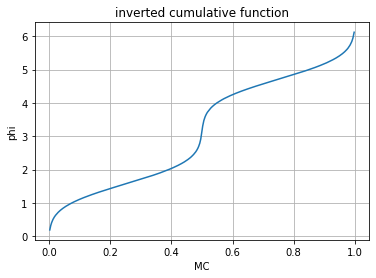

In [14]:
# example photons input
examplePhotons = photons([],[],[],[])  # empty to start, but we need an object to collect results
exampleLookUp = examplePhotons.generatePphiTable(50, 100)  # set 2D size for interpolation table
examplePhotons.scatter(10,examplebeam,exampleNdYAG,exampleLookUp)  # need input beams, like from previous examples
print(examplePhotons)  # here is a set of n photon states,organized in 1D arrays, each of length n.
# spot check interpolated inverse function for phi (e.g. ps=1, P=0.6)
v = np.zeros([500,2])
for x in range(0, 500):  # pick some number to randomly sample (with same Px) and then sort them to plot
    value, phi = examplePhotons.interpolatePhi(1,[0.6],exampleLookUp)
    v[x] = value[0], phi[0]
v = np.sort(v,0)
fig, ax = plt.subplots()
ax.plot(v[:,0], v[:,1])
ax.set(xlabel='MC', ylabel='phi',
       title='inverted cumulative function')
ax.grid()
plt.show()

## Class display: ##
Once we collect data in a 4D histogram, we will need to **display** results.  This class is a place to stash these methods.  Most of these routines are self explanatory.  Generally we want to project (sum) along different axes of interest. Then we view either spatial distributions or spectral distributions.

In [141]:
@dataclass
class display:
    colors: ListedColormap
    range: [float]
    def applyMyColormap(self):
        colordata = np.loadtxt("false_color_256bit_RGB_values.txt", delimiter="\t")
        onescolumn =  np.array([np.ones(256)])
        myvals = np.append(colordata/255, onescolumn.T, axis = 1)
        self.colors = ListedColormap(myvals)
        return
    def setFullView(self, histogram):
        self.range = [-histogram.theta, histogram.theta, -histogram.theta, histogram.theta]
        return
    def viewIntensity(self, data4D, histogram, aperture):
        intensity = np.sum(data4D, axis=(2,3))*aperture.createMask(histogram)
        plt.imshow(intensity[1:-1,1:-1].T, extent=self.range, cmap=self.colors)  # we plot'angle space' xp,yp
        plt.colorbar()
        plt.title(f'{int(np.sum(intensity[:,:]))} photons')
#       plt.title(f'{int(np.sum(intensity[1:-1,1:-1]))} photons') gives incorrect sum (?)
        return
    def fullApertureSpectrum(self, data4D, histogram, aperture):
        mask2D = aperture.createMask(histogram)
        mask3D = np.repeat(mask2D[...,None], 1, axis=2)
        mask4D = np.repeat(mask3D[...,None], 1, axis=3)
        fullspectrum = np.sum(data4D*mask4D, axis=(0,1,3))
        return fullspectrum
    def sampledSpectrum(self, xp, yp, size, data4D, histogram):  
        x = np.searchsorted(histogram.binsThetaArray(),xp)+1
        y = np.searchsorted(histogram.binsThetaArray(),yp)+1
        print(f'spectrum at {xp,yp} rad in a box {(2*size+1)*histogram.dtheta*1e3:0.2f} mrad per side')
        spectrum = np.sum(data4D[x-size:x+size+1, y-size:y+size+1], axis=(0,1,3))
        return spectrum
    def applyAttenuation(self, spectrum, histogram, aperture):   # do this after we have a summed spectrum
        attenuatedSpectrum = spectrum*aperture.transmission(histogram)
        print(f'overall transmission through window = {np.sum(attenuatedSpectrum[1:-1])/np.sum(spectrum[1:-1]):0.3f}')
        return attenuatedSpectrum
    def plotSpectrum(self, spectrum, histogram):  # display a few analysis calcs here too (peak, BW)
        peakE, relBW = self.FWHM(spectrum, histogram)
        fig, ax = plt.subplots()
        ax.plot(histogram.binsEArray(), spectrum[1:-1])
        usefulTitle = f'peak = {peakE/1000:0.2f} keV, rel_FWHM = {relBW*100:0.2f}%'
        ax.set(xlabel='energy (eV)',ylabel = 'counts', title = usefulTitle)
        plt.show() 
        return
    def FWHM(self, spectrum, histogram, peakwidth=4): # check size to remove oob spectrum to match binsE
        sizedSpectrum = spectrum if spectrum.size==histogram.binsEArray().size else spectrum[1:-1]
        peak = find_peaks(sizedSpectrum, height=np.max(sizedSpectrum)*0.9, width=peakwidth)[0]
        peakE = histogram.binsEArray()[peak]
        width = peak_widths(sizedSpectrum, peak, rel_height=0.5)[0]
        widthE = width*histogram.dE
        return peakE[0], widthE[0]/peakE[0]

## We are ready to set up a configuration and run a simulation! ##

Let's use a cython routine to make binning faster.  It definitely improves speed.  I set everything to 64bit, like my local windows compiler, and it works.  This function is called in the main scattering loop in the cell following the `%%cython` cell below.  The idea is to identify the 4D histogram bin **for each photon** after calculating specific values for a batch of photons.  (With this routine it now takes ~0.2s for 1M.)

In [142]:
## first define inputs we will use for the simulation
testconfig = configuration()
readconfig = False # save a config before trying to read one
saveconfig = False  # set to True to save a present configy
if readconfig:
    testconfig.recall()
else:                # manually enter a configuration
    testconfig.mybeam = ebeam(29.2, 3.0E-3, 8.0e-6, 8.0e-6, 0.016, 0.016, True, 0.015, 250e-12)
    testconfig.mylaser = laser(1064, 0, 0.070, 0.050, 30, 140e3)
    testconfig.myluminosity = luminosity([0.000,0.006],[0,10.0e-6],[0.0,0.001],[0,10.0e-6],[0,0.01],[0.0,0.00])
    testconfig.myhistogram = histogram(2.5e-3, 50e-6, 10e3, 30e3, 100)
    testconfig.myaperture = aperture(1.25,6.0e-3,12.7e-3,6.0,225e-6)
if saveconfig:
    testconfig.save()
# use local variables for brevity, and keeps dependencies clear
beam = testconfig.mybeam
NdYAG = testconfig.mylaser
Lum = testconfig.myluminosity
detector = testconfig.myhistogram
window = testconfig.myaperture
print('->', beam)
print('->', NdYAG)
print('->', Lum)
print('->', detector)
print('->', window)
# adjust histogram energy range - comment out next three lines to skip
detector.autoMaxE(beam,NdYAG,-3)
detector.setBW(0.3)
print('new detector  ->', detector)
print(detector.estimateMaxE(beam, NdYAG, precision = -3))
minP = detector.minP(beam,NdYAG)[0]
BW = detector.minP(beam,NdYAG)[1]
print('minimum P [0..1] is', minP, 'for a sampled BW of', BW)
mask = window.createMask(detector)
maskArea = window.properties(detector)[2]  # we can check output area of our aperture 
print(f'output area of window is {maskArea:0.2f} mm^2')
print(f'luminous spot sizes ({Lum.luminousSpot(beam,NdYAG)[0]:0.2e}, {Lum.luminousSpot(beam,NdYAG)[1]:0.2e})')
fullflux = Lum.baseFlux(beam,NdYAG)
reduction = Lum.allReductions(beam, NdYAG, sRange=0.1)
print(f'adjusted full BW flux reduced by factor {reduction:0.3f} to {fullflux*reduction:0.3e}')

-> ebeam(meanMeV=29.2, sigmaErel=0.003, emittanceX=8e-06, emittanceY=8e-06, betastarX=0.016, betastarY=0.016, useNormEmit=True, sigmaZ=0.015, bunchCharge=2.5e-10)
-> laser(nm=1064, ps=0, zRayleighX=0.07, zRayleighY=0.05, psLength=30, cavityPower=140000.0)
-> luminosity(phiX=[0.0, 0.006], dX=[0, 1e-05], phiY=[0.0, 0.001], dY=[0, 1e-05], dSx=[0, 0.01], dSy=[0.0, 0.0])
-> histogram(theta=0.0025, dtheta=5e-05, minE=10000.0, maxE=30000.0, dE=100)
-> aperture(toIP=1.25, dia=0.006, thick=0.0127, angle=6.0, thin=0.000225, material='Si')
  ...new max 16000 replaces 30000 as histogram.maxE
  ...new min 11000 replaces 10000 as histogram.minE
new detector  -> histogram(theta=0.0025, dtheta=5e-05, minE=11000.0, maxE=16000.0, dE=100)
16000.0
minimum P [0..1] is 0.640832 for a sampled BW of 0.31999999999999995
output area of window is 20.42 mm^2
luminous spot sizes (4.54e-05, 3.85e-05)
base flux estimate: 1.704e+12 ph/s full bandwidth         (0.25 nC electron bunch and 140.0 kW cavity power)
adjuste

In [135]:
# split out the intialization of the data array; run this cell to reset data
data = detector.createArray()
print(f"-> {data.shape} = (x', y', E, p) bin sizes")

-> (102, 102, 52, 3) = (x', y', E, p) bin sizes


In [143]:
%%cython
cimport numpy as np
def cyBin(long long n, 
          np.ndarray[np.int64_t, ndim=1] xp,
          np.ndarray[np.int64_t, ndim=1] yp, 
          np.ndarray[np.int64_t, ndim=1] eV, 
          np.ndarray[np.int64_t, ndim=1] ps, 
          np.ndarray[np.int64_t, ndim=4] data):
    for q in range (0, n):
        data[xp[q],yp[q],eV[q],ps[q]] = data[xp[q],yp[q],eV[q],ps[q]] + 1
    return data

In [137]:
# main routine to generate spatial and spectral distribution of ICS
# note [data] will accumulate in multiple calls running this cell until previous cell is run again
S = photons([],[],[],[]) # container for the state of a batch of photons [xp],[yp],[eV],[ps]
lookUpTable = S.generatePphiTable(50, 100, 0.01)  # do this once for interpolation table
batch = 1000000  # do batch of n at at time (e.g. 1e6)
runs = 10 # loop this many times and bin data each time
tic = time.perf_counter()  # measure start of batch calculation
print('OK, here we go...it may take a few seconds...')
for i in range(0, runs):  # do a batch at a time, bin results, and repeat. This is one way to accumulate data.
    mtic = time.perf_counter()
    S.scatter(batch,beam,NdYAG,lookUpTable,minP)     # generate scattered ICS photons as a 'point source'
    S.addBeamDivergence(beam, Lum)       # make a data copy if interested in changing later 
    S.addLuminousSpot(beam, NdYAG, Lum, window) # make a data copy if interested in changing later 
    # the following lines bin the photon state in to the histogram
    xp = np.where(np.abs(S.xp) < detector.theta, np.searchsorted(detector.binsThetaArray(),S.xp)+1, 0)
    yp = np.where(np.abs(S.yp) < detector.theta, np.searchsorted(detector.binsThetaArray(),S.yp)+1, 0)
    eV = np.where(S.eV > detector.minE, np.searchsorted(detector.binsEArray(),S.eV)+1, 0)
    ps = np.searchsorted([-1,0,1],S.ps)
    # then loop over every photon and assign it to a unique bin, which gets incremented by 1
    data = cyBin(batch, xp, yp, eV, ps, data)  # do this in cython! 10x faster than two lines below
#    for q in range (0,batch):
#        data[xp[q],yp[q],eV[q],ps[q]] = data[xp[q],yp[q],eV[q],ps[q]] + 1
    mtoc = time.perf_counter()
    print(f"run {i+1}/{runs} {mtoc - mtic:0.3f}s: total events now {np.sum(data):0.1e}")
toc = time.perf_counter()
print(f'The Monte Carlo part took {toc - tic:0.2f} seconds')
# The following examples count photons from the 4D histogram
print(f'TOTAL scattering events = {np.sum(data):0.1e} in top BW of {BW*100:0.1f}%')
ondetector_count = np.sum(data[1:-1,1:-1,1:-1,:])
ondetect_p_count = np.sum(data[1:-1,1:-1,1:-1,0])
ondetect_s_count = np.sum(data[1:-1,1:-1,1:-1,2])
print('ON detector count =', ondetector_count,'(p pol =',ondetect_p_count,': s pol =',ondetect_s_count,')')
lowE_count = np.sum(data[:,:,0,:])
highE_count = np.sum(data[:,:,-1,:])
print('lowE count =', lowE_count, '; highE count =', highE_count)
onEoffX_count = np.sum(data[0,:,1:-1,:])+np.sum(data[-1,:,1:-1,:])
onEoffY_count = np.sum(data[:,0,1:-1,:])+np.sum(data[:,-1,1:-1,:])
print('onEoffX count =', onEoffX_count, '; onEoffY count =', onEoffY_count)

OK, here we go...it may take a few seconds...
run 1/10 7.485s: total events now 1.0e+06
run 2/10 7.611s: total events now 2.0e+06
run 3/10 7.567s: total events now 3.0e+06
run 4/10 7.471s: total events now 4.0e+06
run 5/10 7.715s: total events now 5.0e+06
run 6/10 7.465s: total events now 6.0e+06
run 7/10 7.626s: total events now 7.0e+06
run 8/10 7.441s: total events now 8.0e+06
run 9/10 7.676s: total events now 9.0e+06
run 10/10 7.470s: total events now 1.0e+07
The Monte Carlo part took 75.54 seconds
TOTAL scattering events = 1.0e+07 in top BW of 32.0%
ON detector count = 859774 (p pol = 0 : s pol = 0 )
lowE count = 1049528 ; highE count = 0
onEoffX count = 6099548 ; onEoffY count = 6102046


## Following examples show various ways how to look at the data ##

overall transmission through window = 0.564


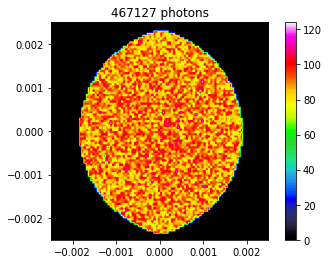

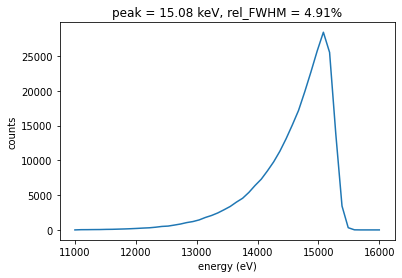

spectrum sum 467127.0 should match one in intensity plot (no attenuation)
spectrum sum 263115.1 is after window transmission and plotted above
relative flux through aperture (from *total* luminosity, BW = 1): 9.450e-03
in absolute ph/s, this would be 1.343e+10


In [148]:
# set up plots
myview = display(ListedColormap,[])
myview.applyMyColormap()  # I like this lasercam false color display and use it everywhere
myview.setFullView(detector)
# intensity plot
myview.viewIntensity(data,detector,window)
# get the overall spectrum of beam that makes it through aperture
fullspectrum = myview.fullApertureSpectrum(data,detector,window)
spectrum = myview.applyAttenuation(fullspectrum, detector, window)
myview.plotSpectrum(spectrum, detector)
print(f'spectrum sum {np.sum(fullspectrum)} should match one in intensity plot (no attenuation)') 
print(f'spectrum sum {np.sum(spectrum):0.1f} is after window transmission and plotted above')
# if we want to scale a luminosity formula, we can calculate the fraction of "full bandwidth" scattering
# this fraction compensates sampled BW if it is high enough not to cut-off energies that should be in the histogram
rel_flux_in_aperture = np.sum(spectrum)/np.sum(data)*(1-minP)  # minP defined earlier = detector.minP(beam,NdYAG)[0]
print(f'relative flux through aperture (from *total* luminosity, BW = 1): {rel_flux_in_aperture:0.3e}')
print(f'in absolute ph/s, this would be {fullflux*reduction*rel_flux_in_aperture:0.3e}')

spectrum at (0.0, 0.001) rad in a box 0.35 mrad per side


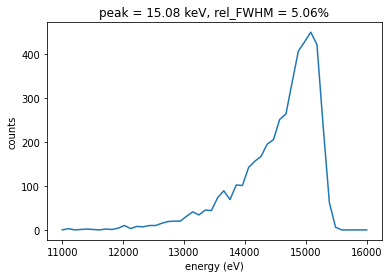

In [145]:
# we could zoom in to a particular spot to see local spectrum
spotspectrum = myview.sampledSpectrum(0.000,0.001,3,data,detector) # give coordinates xp, yp, and bin size b (2n+1 x 2n+1)
myview.plotSpectrum(spotspectrum, detector)

0.1 mrad is 1 bins
spectrum at (0.0, 0.0) rad in a box 0.15 mrad per side
total number of photons = 871


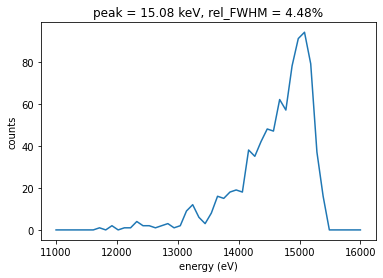

In [146]:
# quick estimate to see a central spectrum over a smaller aperture (say 0.1 mrad) **square**
b = int(1e-4/detector.dtheta/2)
print(f'0.1 mrad is {b} bins')
spotspectrum = myview.sampledSpectrum(0.000,0.000,b,data,detector) # give coordinates xp, yp, and bin size b (2n+1 x 2n+1)
print(f'total number of photons = {np.sum(spotspectrum)}')
myview.plotSpectrum(spotspectrum, detector)

window        -> aperture(toIP=1.0, dia=0.001, thick=0, angle=0, thin=0, material='Si')
overall transmission through window = 0.567


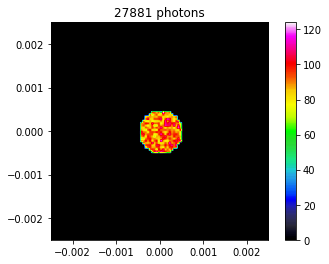

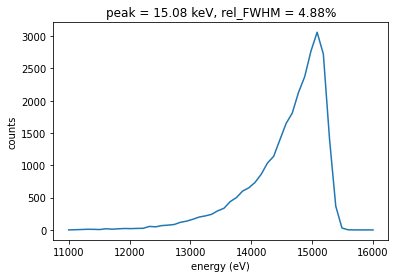

In [147]:
# another way to see central spectrum over a smaller aperture (say 4 mrad **round**) is create a new aperture!
alternate_window = aperture(1.0,1.0e-3,0,0,0)  # use simple geometry to set angle (i.e. IP at 1m)
print('window        ->', alternate_window)
# plot intensity and new 'full' spectrum
myview.viewIntensity(data,detector,alternate_window)
new_fullspectrum = myview.fullApertureSpectrum(data,detector,alternate_window)
new_spectrum = myview.applyAttenuation(new_fullspectrum, detector, window) # if you want to keep old window transmission
myview.plotSpectrum(new_fullspectrum, detector)